In [2]:
import pandas as pd
import torch
import torch.nn as nn
# import vaex
import numpy as np
import glob
import dask.dataframe as dd
import json
from sklearn.model_selection import train_test_split
import math
import csv
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import time
import _warnings
from tqdm import tqdm
import swifter
import argparse
import os
from copy import copy, deepcopy
from pathlib import Path
from concurrent import futures
from functools import partial
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from collections import Counter
from matplotlib import pyplot
from numpy import where
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.cluster import MiniBatchKMeans


epochs_number = 1  # number of epochs for the neural networks
test_set_size = 0.2  # percentage of the test size comparing to the whole dataset
oversampling_flag = 1  # set to 1 to over-sample the minority class
oversampling_percentage = 0.2  # percentage of the minority class after the oversampling comparing to majority class

In [75]:
import sys
import os

%load_ext autoreload
%autoreload 2

sys.path.append('../')
sys.path.insert(0, os.path.dirname(os.getcwd()) + "/../")

print(sys.path)

['/home/tiendat/electric-theft-detection/../', '/home/tiendat/electric-theft-detection/notebooks', '/home/tiendat/miniconda3/envs/torchtf/lib/python39.zip', '/home/tiendat/miniconda3/envs/torchtf/lib/python3.9', '/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


# PREPROCESSING

In [3]:
# https://github.com/yvesheri4/Identification-of-Electricity-Theft

threshold = 600  # Set the threshold for NaN values

# Load the data
rawData = pd.read_csv('../data/data.csv')

infoData = pd.DataFrame()
infoData['FLAG'] = rawData['FLAG']
infoData['CONS_NO'] = rawData['CONS_NO']
data = rawData.drop(['FLAG', 'CONS_NO'], axis=1)  

# Process Data
# change column name to dates(2014/1/1 to 2014-01-01)
data.columns = pd.to_datetime(data.columns)  #columns reindexing according to dates
data = data.reindex(sorted(data.columns), axis=1)   # sort data accoding to date(as previusoly column are unsorted)

#droping duplicate row (31683 if not using)
dropIndex = data[data.duplicated()].index  # duplicates drop
data = data.drop(dropIndex, axis=0)   
infoData = infoData.drop(dropIndex, axis=0)

# Get index of rows with more than 600 NaNs
overthreshhold_index = data[data.isnull().sum(axis=1) > threshold].index  
data = data.drop(overthreshhold_index)
infoData = infoData.drop(overthreshhold_index, axis=0)

#removing row with all zero(Nan) value
zeroIndex = data[(data.sum(axis=1) == 0)].index  # zero rows drop
data = data.drop(zeroIndex, axis=0) 
infoData = infoData.drop(zeroIndex, axis=0) 

# reindex row name (as some row has been remove till this step due to duplicate or all nan values)
data.reset_index(inplace=True, drop=True)  # index sorting
infoData.reset_index(inplace=True, drop=True)

data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
30359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
30360,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
30361,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


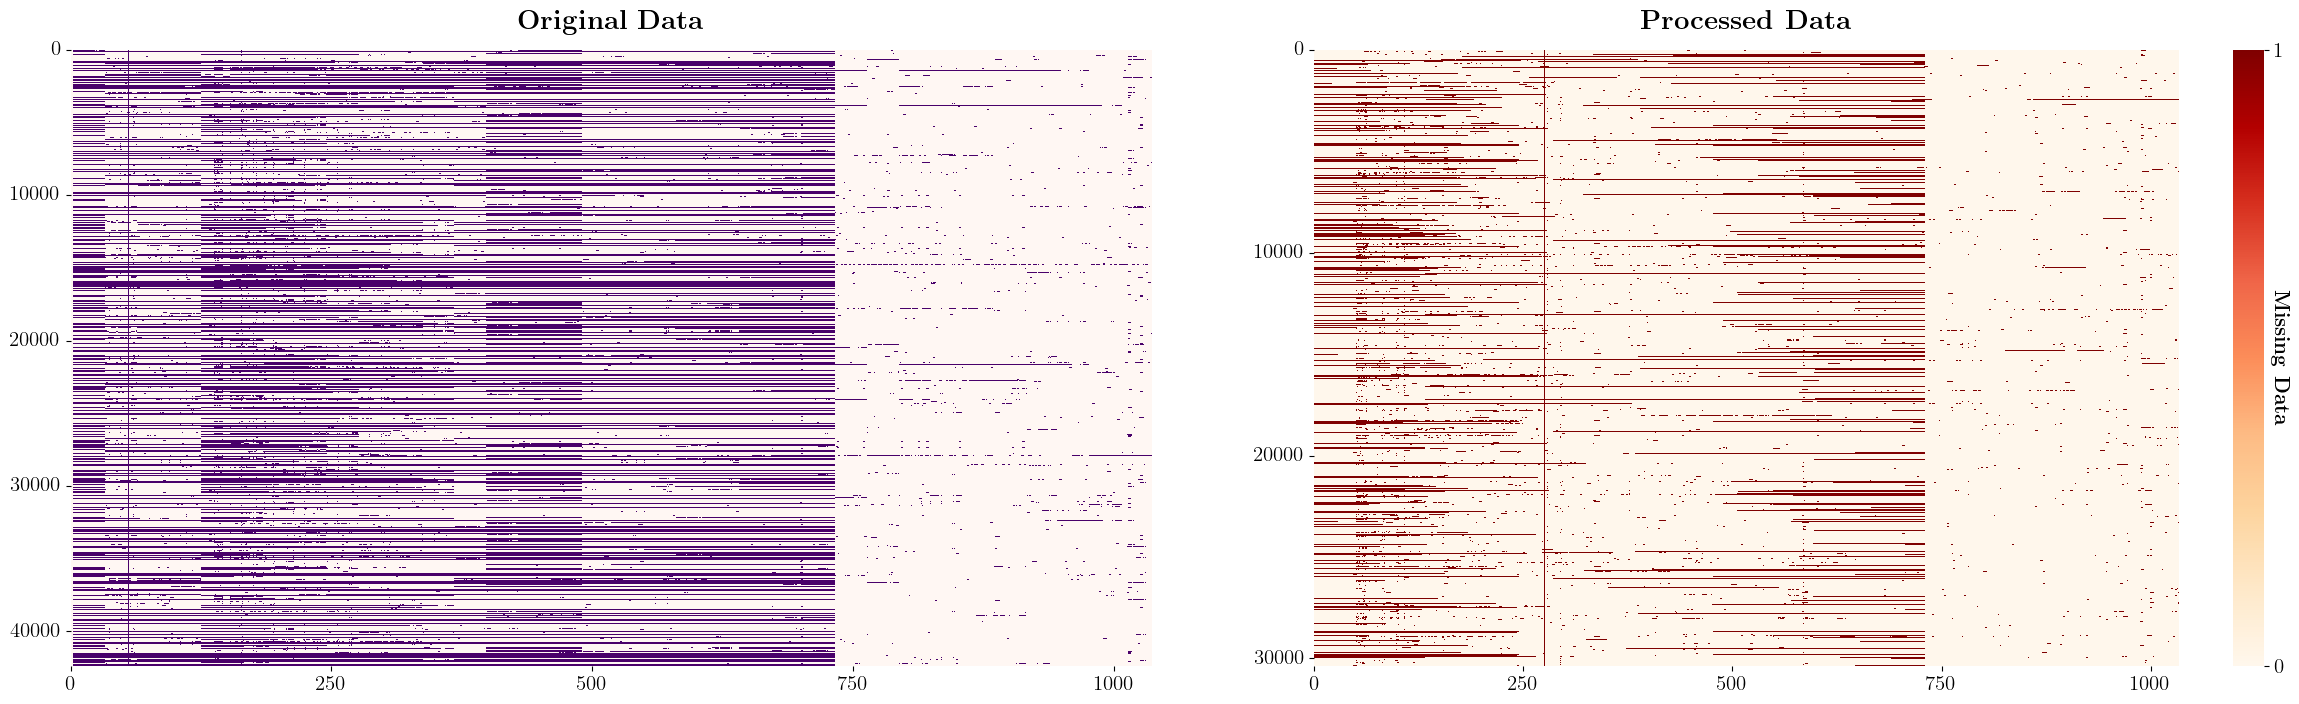

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(30,8))

sns.heatmap(rawData.transpose().isna().transpose(),
            cmap="RdPu", ax=axs[0], cbar=False)
axs[0].set_title(r'\textbf{Original Data}', fontsize=20, y=1.02)
axs[0].set_xticks([0, 250, 500,750,1000])
axs[0].set_xticklabels([0, 250, 500,750,1000], rotation=0, fontsize=15)
axs[0].set_yticks([0,10000, 20000, 30000, 40000])
axs[0].set_yticklabels([0, 10000, 20000, 30000, 40000], fontsize=15)

# cmap="OrRd"
cbar_ax = sns.heatmap(data.transpose().isna().transpose(),
            cmap="OrRd",
            cbar_kws={"ticks":[0,1]}, ax=axs[1]).collections[0].colorbar

# Set the label size of the colorbar
cbar_ax.ax.yaxis.set_tick_params(labelsize=15)
cbar_ax.set_label(r'\textbf{Missing Data}', rotation=-90, size=15)

axs[1].set_title(r'\textbf{Processed Data}', fontsize=20, y=1.02)
axs[1].set_xticks([0, 250, 500,750,1000])
axs[1].set_xticklabels([0, 250, 500,750,1000], rotation=0, fontsize=15)
axs[1].set_yticks([0,10000, 20000,30000])
axs[1].set_yticklabels([0,10000, 20000,30000], fontsize=15)

plt.subplots_adjust(wspace=0.15)
plt.show()

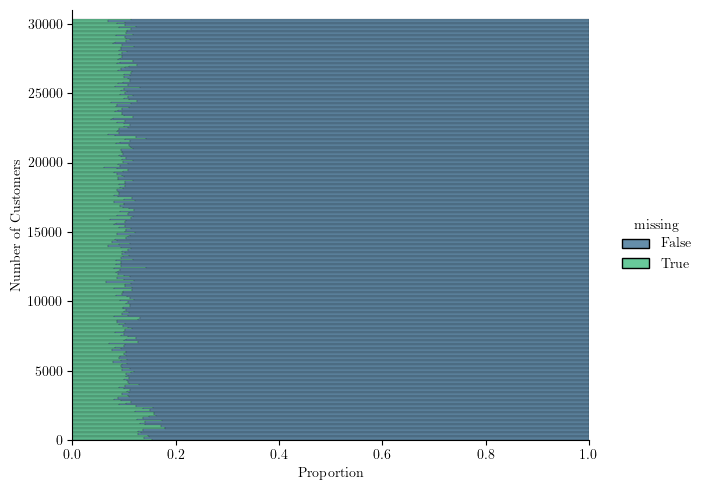

In [62]:
b=sns.displot(
    data=data.transpose().isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25,
    palette="viridis"
)
# b.set_xticklabels(size = 12)
# b.set_yticklabels(size = 12)
plt.xlabel('Proportion')
plt.ylabel('Number of Customers')
plt.ylim([0,31000])
plt.show()
# plt.savefig('missing_P.png')


In [4]:
balancing_data = data.copy(deep=True)
balancing_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
30359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
30360,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
30361,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


### Fill the missing values

In this work, we exploit the interpolation method to recover the missing values according to the following equation,

\begin{equation}
f(x_i)=
\begin{cases}
\frac{x_{i-1}+x_{i+1}}{2} \quad  x_i \in NaN,\;x_{i-1},x_{i+1} \notin NaN \\
0 \quad\quad\quad \;  x_i \in NaN,\;x_{i-1}\;or\; x_{i+1} \in NaN \\
x_i \quad \quad \quad  x_i \notin NaN
\end{cases}
\end{equation}

The interpolate() function uses existing values in the DataFrame to estimate the missing rows.

In [5]:
balancing_data = balancing_data.interpolate(method='linear', limit=2, limit_direction='both', axis=1).fillna(0)
balancing_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30358,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
30359,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
30360,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
30361,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


### Handling the outliers

We restore the value by following equation according to "Three-sigma rule of dumb"

\begin{equation}
f(x_i)=
\begin{cases}
avg(\mathbf{x})+3\cdot std(\mathbf{x}) \quad  if \; x_i > avg(\mathbf{x})+3\cdot std(\mathbf{x})\\
x_i \quad \quad \quad otherwise
\end{cases}
\end{equation}

In [6]:
for i in range(balancing_data.shape[0]):  # outliers treatment
    m = balancing_data.loc[i].mean()
    st = balancing_data.loc[i].std()
    balancing_data.loc[i] = balancing_data.loc[i].mask(balancing_data.loc[i] > (m + 3 * st), other=m + 3 * st)
balancing_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30358,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
30359,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
30360,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
30361,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [48]:
# preprocessed data without scaling
preprData = pd.concat([infoData, balancing_data], axis=1, sort=False)  # Back to initial format
preprData
preprData.to_csv(r'../data/processed_data2.csv', index=False, header=True)

In [7]:
test_data = balancing_data.copy(deep=True)

In [20]:
df_datainfo = pd.read_csv('../data/new_info2.csv')
df_datainfo.drop(['Unnamed: 0'], axis=1, inplace=True)
df_datainfo

,FLAG,CONS_NO
0,1,0387DD8A07E07FDA6271170F86AD9151
1,1,B32AC8CC6D5D805AC053557AB05F5343
2,1,EDFC78B07BA2908B3395C4EB2304665E
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83
4,1,768309B0EB11FD436CEE5ABFB84F4C0C
...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107
31679,0,F1472871E1AFF49D4289564B6377D76C
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7
31681,0,A9A0FE83467A680FBFB0DBFC910DF227


In [19]:
H_dataset = pd.read_csv('../data/processed_data_H.csv').drop(['Unnamed: 0'], axis=1)
H_dataset

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [24]:
# Normalization
scale = MinMaxScaler()
test_data = H_dataset.copy(deep=True)

scaled = scale.fit_transform(test_data.values.T).T
# mData = pd.DataFrame(data=scaled, columns=balancing_data.columns)
mData = pd.DataFrame(data=scaled, columns=H_dataset.columns)
mData

preprData = pd.concat([df_datainfo, mData], axis=1, sort=False)
# preprData = pd.concat([df_datainfo, mData], axis=1, sort=False)
# preprData
preprData.to_csv(r'../data/H_dataset_minmax.csv', index=False, header=True)

In [25]:
# Standardization
scale = StandardScaler()
test_data = H_dataset.copy(deep=True)

scaled = scale.fit_transform(test_data.values.T).T
mData = pd.DataFrame(data=scaled, columns=H_dataset.columns)
# mData = pd.DataFrame(data=scaled, columns=df_processedH.columns)
mData
preprData = pd.concat([df_datainfo, mData], axis=1, sort=False)
# preprData = pd.concat([df_datainfo, mData], axis=1, sort=False)
preprData.to_csv(r'../data/H_dataset_standard.csv', index=False, header=True)

### VISUALIZE

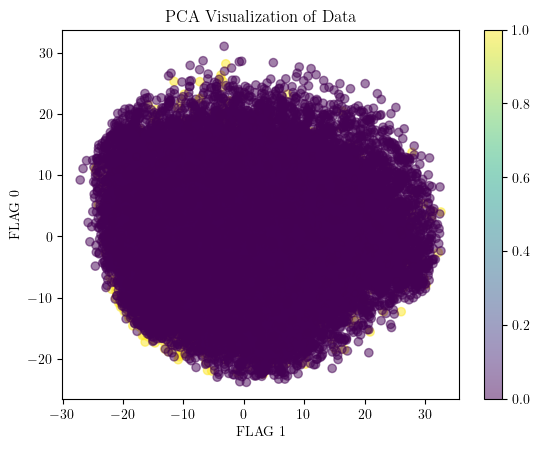

In [12]:
# Performing PCA to reduce the dimensionality of x for visualization
pca = PCA(n_components=2)
x_pca = pca.fit_transform(mData)

# Ensure that the number of labels in y matches the number of data points in x_pca
assert len(x_pca) == len(infoData['FLAG']), "The number of data points in x_pca does not match the number of labels in y."

# Plotting the reduced x in 2D
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=infoData['FLAG'], cmap='viridis', alpha=0.5)
plt.xlabel('FLAG 1')
plt.ylabel('FLAG 0')
plt.title('PCA Visualization of Data')
plt.colorbar()
plt.show()

In [5]:
cleaned_df = pd.read_csv('../data/processed_data_H.csv')
cleaned_df.drop(['Unnamed: 0'], axis=1, inplace=True)
cleaned_df

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


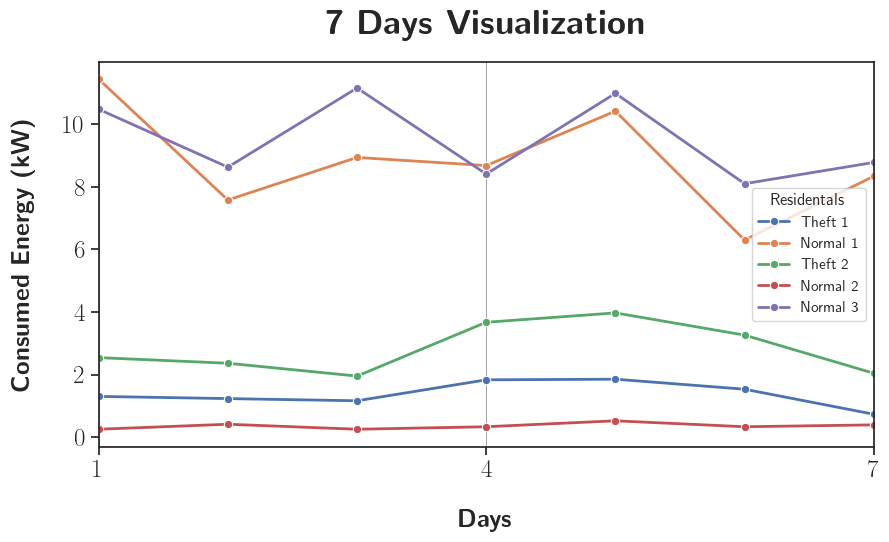

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

# rows = [cleaned_df.iloc[0, 0:28] for _ in range(5)]
# Assuming df is your DataFrame and you want to visualize the first row
rows = cleaned_df.iloc[[7, 2590, 10, 3617, 26723], 301:308]
# rows = [cleaned_df.iloc[2609, 0+28*i:28*i+28] for i in range(1, 10)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 8)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["Theft 1" for _ in range(7)], ["Normal 1" for _ in range(7)], ["Theft 2" for _ in range(7)], ["Normal 2" for _ in range(7)], ["Normal 3" for _ in range(7)]]).flatten().tolist()
})


# Set a theme
# sns.axes_style()
sns.set_theme(style="ticks")

# Create a lineplot
plt.figure(figsize=(10, 5))

sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o')

# Define the markers
# markers = ['o', 'v', '^', '<', '>']

# Get the unique residentals
# residentals = data['Residentals'].unique()

# Create a lineplot for each residental
# for i, residental in enumerate(residentals):
#     df_residental = data[data['Residentals'] == residental]
#     sns.lineplot(x='Day', y='Value', data=df_residental, marker=markers[i % len(markers)], linewidth=2)

# Add title and labels
plt.title(r'\textbf{7 Days Visualization}', fontsize=25, pad=20)
plt.xlabel(r'\textbf{Days}', fontsize=18, labelpad=20)
plt.ylabel(r'\textbf{Consumed Energy (kW)}', fontsize=18, labelpad=20)

# Set xticks to only show the first and last day
plt.xticks([0, 1, 4, 7], fontsize=18)
plt.yticks(fontsize=18)

# Get the current axes, enabling you to manipulate its properties
ax = plt.gca()

# Display only vertical gridlines
ax.grid(True, which='both', axis='x', color='gray', linewidth=0.5)

# Set x-axis limits
plt.xlim(1, 7)

# Show the plot
plt.show()

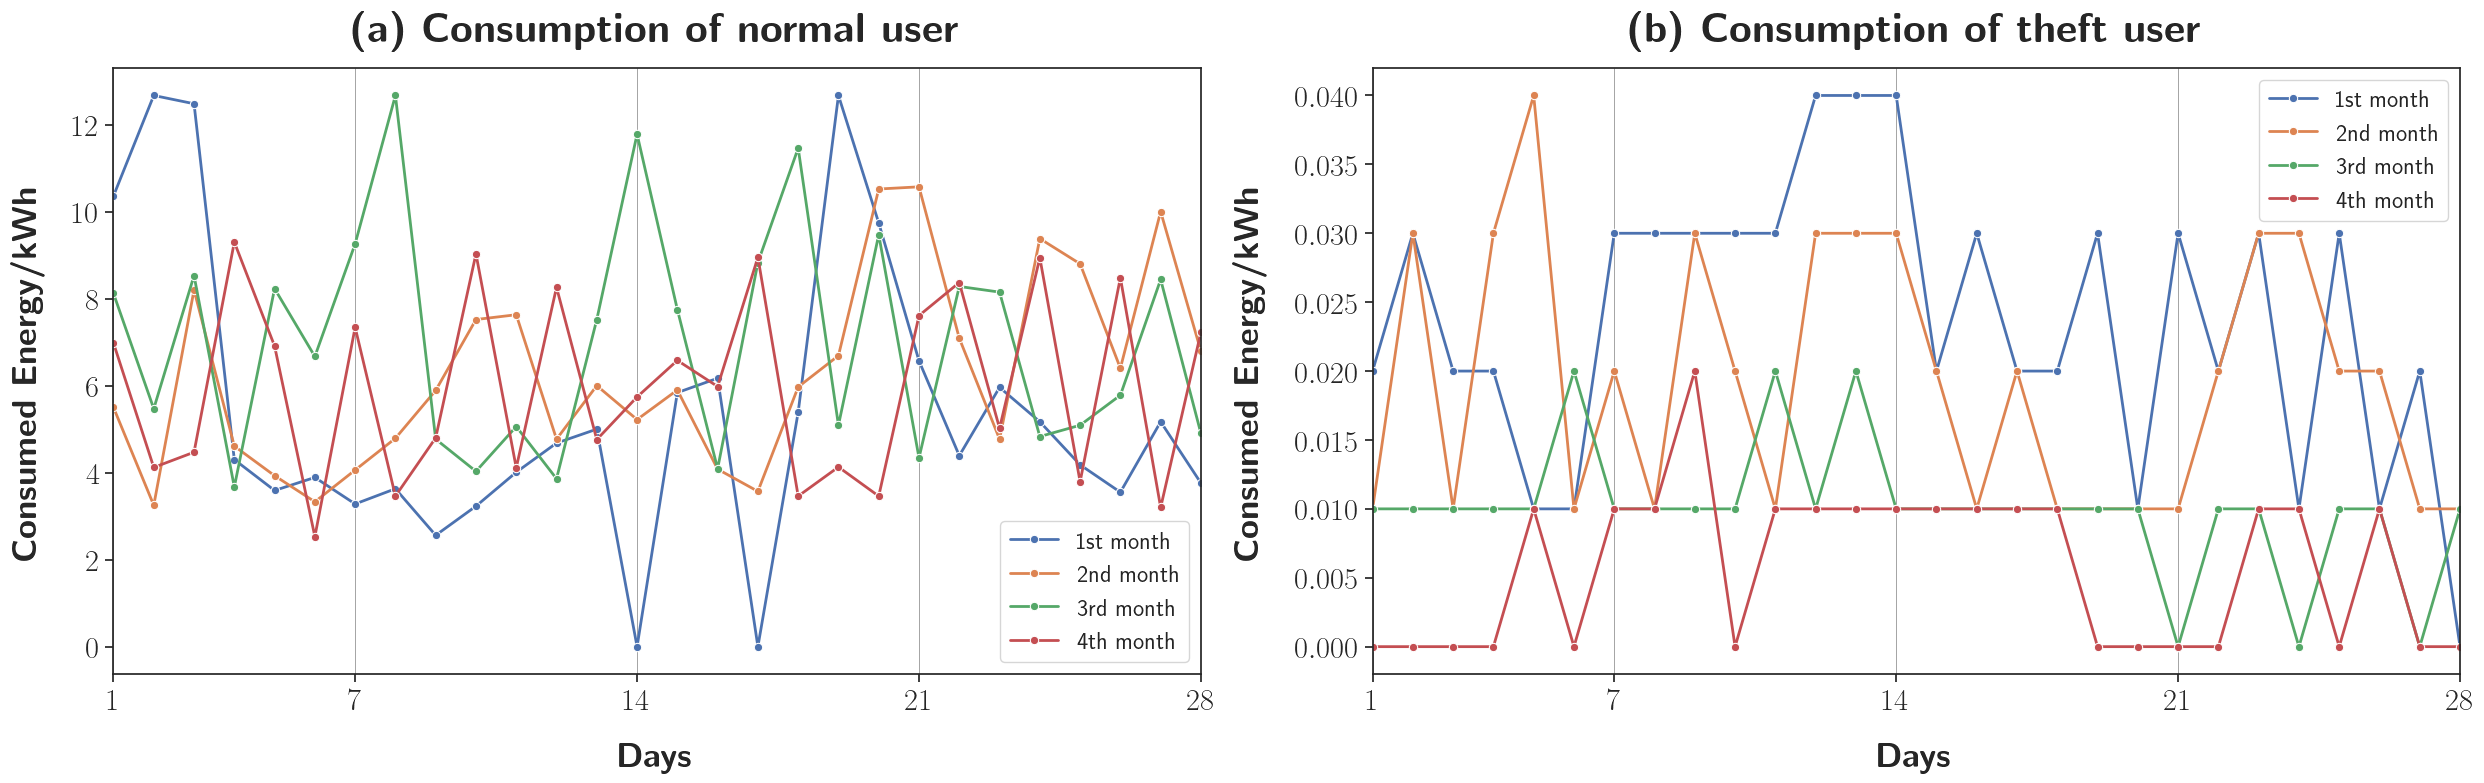

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

sns.set_theme(style="ticks")

# Assuming df is your DataFrame and you want to visualize the first row
rows = [cleaned_df.iloc[8976, 0+28*i:28*i+28] for i in range(1, 5)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["1st month" for _ in range(28)], ["2nd month" for _ in range(28)], ["3rd month" for _ in range(28)], ["4th month" for _ in range(28)]]).flatten().tolist()
})

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Create the first lineplot
sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o', ax=axs[0])
axs[0].set_title(r'\textbf{(a) Consumption of normal user}', fontsize=30, pad=20)
axs[0].set_xlabel(r'\textbf{Days}', fontsize=25, labelpad=20)
axs[0].set_ylabel(r'\textbf{Consumed Energy/kWh}', fontsize=25, labelpad=20)
axs[0].set_xticks([0, 1, 7, 14, 21, 28])
axs[0].tick_params(axis='both', which='major', labelsize=22) 
axs[0].grid(True, which='both', axis='x', color='gray', linewidth=0.5)
axs[0].set_xlim(1, 28)
axs[0].legend(fontsize='x-large')  # Change font size of legend

# Assuming df is your DataFrame and you want to visualize the first row
rows = [cleaned_df.iloc[100, 0+28*i:28*i+28] for i in range(1, 5)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["1st month" for _ in range(28)], ["2nd month" for _ in range(28)], ["3rd month" for _ in range(28)], ["4th month" for _ in range(28)]]).flatten().tolist()
})

# Create the second lineplot
# (replace 'data2' with your second DataFrame)
sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o', ax=axs[1])
axs[1].set_title(r'\textbf{(b) Consumption of theft user}', fontsize=30, pad=20)
axs[1].set_xlabel(r'\textbf{Days}', fontsize=25, labelpad=20)
axs[1].set_ylabel(r'\textbf{Consumed Energy/kWh}', fontsize=25, labelpad=20)
axs[1].set_xticks([0, 1, 7, 14, 21, 28])
axs[1].tick_params(axis='both', which='major', labelsize=22) 
axs[1].grid(True, which='both', axis='x', color='gray', linewidth=0.5)
axs[1].set_xlim(1, 28)
axs[1].legend(fontsize='x-large')  # Change font size of legend

# Show the plot
plt.tight_layout()
plt.show()

# Non sampling training

In [64]:
processed_data = pd.read_csv('../data/processed_data_H.csv')
processed_data.drop(['Unnamed: 0'], axis=1, inplace=True)
processed_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [65]:
flag = pd.read_csv('../data/new_info2.csv')
flag.drop(['Unnamed: 0'], axis=1, inplace=True)
flag

,FLAG,CONS_NO
0,1,0387DD8A07E07FDA6271170F86AD9151
1,1,B32AC8CC6D5D805AC053557AB05F5343
2,1,EDFC78B07BA2908B3395C4EB2304665E
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83
4,1,768309B0EB11FD436CEE5ABFB84F4C0C
...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107
31679,0,F1472871E1AFF49D4289564B6377D76C
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7
31681,0,A9A0FE83467A680FBFB0DBFC910DF227


In [67]:
df_combined = pd.concat([flag, processed_data], axis=1)
df_combined

,FLAG,CONS_NO,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,1,0387DD8A07E07FDA6271170F86AD9151,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,1,B32AC8CC6D5D805AC053557AB05F5343,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,1,EDFC78B07BA2908B3395C4EB2304665E,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,1,768309B0EB11FD436CEE5ABFB84F4C0C,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0,F1472871E1AFF49D4289564B6377D76C,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0,A9A0FE83467A680FBFB0DBFC910DF227,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [68]:
sampling_df = df_combined.copy(deep=True)

## SMOTE balancing
work with outliner data

In [ ]:
from sklearn.model_selection import train_test_split

def SMOTE_Eval(A,B,pre):
    y_trainWS=B.sample(frac=0.05)
    X_trainWS=A.sample(frac=0.075)
    # summarize class distribution
    counter = Counter(y_trainWS)
    print(counter)
    # scatter plot of examples by class label
    pyplot.figure(figsize=(5.5,4.5))

    for label, _ in counter.items():
        row_ix = where(y_trainWS == label)[0]
        pyplot.scatter(X_trainWS.iloc[row_ix, 0], X_trainWS.iloc[row_ix, 1], label=str(label), alpha=0.8)
    pyplot.xlabel('X')
    pyplot.ylabel('Y')
    pyplot.legend()
    # pyplot.savefig(pre+'_smote.png',dpi=200)
    pyplot.show()

# Definition of functions
def read_data(size):
    rawData = pd.read_csv('../data/processed_data2.csv')

    # Setting the target and dropping the unnecessary columns
    y = rawData[['FLAG']]
    X = rawData.drop(['FLAG', 'CONS_NO'], axis=1)

    print('Normal Consumers:                    ', y[y['FLAG'] == 0].count()[0])
    print('Consumers with Fraud:                ', y[y['FLAG'] == 1].count()[0])
    print('Total Consumers:                     ', y.shape[0])
    print("Classification assuming no fraud:     %.2f" % (y[y['FLAG'] == 0].count()[0] / y.shape[0] * 100), "%")

    # columns reindexing according to dates
    X.columns = pd.to_datetime(X.columns)
    X = X.reindex(X.columns, axis=1)
    
    # Splitting the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y['FLAG'], train_size=size, random_state=1999)
    
    print("Test set assuming no fraud:           %.2f" % (y_test[y_test == 0].count() / y_test.shape[0] * 100), "%\n")
    SMOTE_Eval(X_train,y_train,'without')
    
    # Oversampling of minority class to encounter the imbalanced learning
    if oversampling_flag == 1:
        over = SMOTE(random_state=1999)
        # over = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=1, n_clusters=64, random_state=0), random_state=1999)
        undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=1999)
        
        X_train, y_train = over.fit_resample(X_train, y_train)
        X_train, y_train = undersampler.fit_resample(X_train, y_train)

        print("Oversampling statistics in training set: ")
        print('Normal Consumers:                    ', y_train[y_train == 0].count())
        print('Consumers with Fraud:                ', y_train[y_train == 1].count())
        print("Total Consumers                      ", X_train.shape[0])
    SMOTE_Eval(X_train,y_train,'with')
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=read_data(0.8)

In [56]:
df_combined = pd.concat([flag, cleaned_df], axis=1)
df_combined

,FLAG,CONS_NO,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,1,0387DD8A07E07FDA6271170F86AD9151,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,1,B32AC8CC6D5D805AC053557AB05F5343,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,1,EDFC78B07BA2908B3395C4EB2304665E,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,1,768309B0EB11FD436CEE5ABFB84F4C0C,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0,F1472871E1AFF49D4289564B6377D76C,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0,A9A0FE83467A680FBFB0DBFC910DF227,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [57]:
sampling_df = processed_data.copy(deep=True)
# sampling_df = df_combined.copy(deep=True)

In [70]:
# sampling_df = pd.read_csv('../data/processed_data_H.csv')
# infoData = pd.read_csv('../data/new_info2.csv')

x = sampling_df.iloc[:, 2:].values
y = sampling_df.iloc[:, 0].values

# x = sampling_df.drop(['Unnamed: 0'], axis=1)
# y = sampling_df['FLAG']

resample = pd.DataFrame(x)
print(resample.shape)
resample.head()

(31683, 1034)


,0,1,2,3,4,5,6,7,8,9,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91


In [71]:
#df_pr['data'] = df_pr[df_pr.columns].astype(float).values.tolist()
resample['data'] = resample[resample.columns].values.tolist()
df_apr = resample['data']
df_apr

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [2.9, 5.64, 6.99, 3.32, 3.61, 5.35, 4.73, 3.68...
3        [0.11, 0.11, 0.25, 0.27, 0.21, 0.2, 0.14, 0.34...
4        [0.91, 1.16, 0.75, 1.3, 0.74, 0.94, 0.85, 1.21...
                               ...                        
31678    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
31679    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
31680    [2.7, 0.0, 0.0, 5.72, 6.05, 5.81, 3.07, 4.04, ...
31681    [0.58, 1.16, 0.92, 0.98, 1.54, 1.38, 0.89, 0.7...
31682    [16.89, 15.15, 19.28, 17.19, 16.8, 17.48, 17.8...
Name: data, Length: 31683, dtype: object

In [74]:
from utils import stride

df_apr = df_apr.apply(stride)
df_apr

ImportError: cannot import name 'stride' from 'utils' (/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/site-packages/utils/__init__.py)

In [26]:
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    Parameters:
    actual (list): A list of true labels.
    predicted (list): A list of predicted labels (ordered by score).
    k (int): The maximum number of predicted elements.

    Returns:
    score (float): The average precision at k.
    """

    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    Parameters:
    actual (list of lists): A list of lists of true labels.
    predicted (list of lists): A list of lists of predicted labels (ordered by score).
    k (int): The maximum number of predicted elements.

    Returns:
    score (float): The mean average precision at k.
    """
    
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# Example usage:
# True labels for 3 samples
actual = [[1, 0, 1], [1, 0, 0], [0, 1, 1]]

# Predicted labels for 3 samples (ordered by prediction score)
predicted = [[0, 1, 1], [1, 1, 0], [0, 0, 1]]

# Compute MAP@K
k = 1
mapk_score = mapk(actual, predicted, k)
print(f"MAP@{k}: {mapk_score}")

MAP@1: 1.0


## K-means SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.cluster import MiniBatchKMeans

def undersampling(X, y, ratio=1.0, choice=1):
    # Count of number of samples in each class
    class_counts = Counter(y)

    # Determining the class with fewer samples
    minority_class = min(class_counts, key=class_counts.get)
    majority_class = max(class_counts, key=class_counts.get)

    # Creating SMOTE and Undersampler instances with the specified ratio
    undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=42)
    SMOTE_Eval(X,y,'without')
    
    if choice == 0:
        print("Using SMOTE")
        smote = SMOTE(sampling_strategy=ratio, random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    elif choice == 1:
        print("Using ADASYN")
        adasyn = ADASYN(sampling_strategy=ratio, random_state=42)
        X_resampled, y_resampled = adasyn.fit_resample(X, y)
    else: 
        print("Using KMeansSMOTE")
        kmean_sm = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=1, n_clusters=8, random_state=0), random_state=42)
        # MAX-Min 64
        # Standard 160
        X_resampled, y_resampled = kmean_sm.fit_resample(X, y)
        
        
    # Applying undersampling to reduce the number of samples in the majority class
    X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)
    
    # Counting the number of samples in each class in the final resampled dataset
    final_class_counts = Counter(y_resampled)

    return X_resampled, y_resampled, final_class_counts

desired_ratio = 1.0
# SEPARATING DEPENDENT AND INDEPENDENT VARIABLES
x = sampling_df.iloc[:, 2:].values
y = sampling_df.iloc[:, 0].values
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

x_resampled, y_resampled, final_class_counts = undersampling(x, y, ratio=desired_ratio, choice=2)

# The final_class_counts will now contain equal numbers of samples for both classes
print("Final class counts:", final_class_counts)

In [78]:
# Blancing version only training set

X_traindf = pd.DataFrame(X_train)
X_testdf = pd.DataFrame(X_test)
print('Shape of X train ', X_traindf.shape, ' Shape of X test ', X_testdf.shape)
print('Shape of y train ', y_train.shape, ' Shape of y test ', y_test.shape)

Shape of X train  (44522, 1034)  Shape of X test  (6073, 1034)
Shape of y train  (44522,)  Shape of y test  (6073,)


In [ ]:
# Blancing version whole dataset

print(y_resampled.shape)
resample = pd.DataFrame(x_resampled)
resample.head()

## Continue split data

In [79]:
# Blancing version only training set

X_traindf['data'] = X_traindf[X_traindf.columns].values.tolist()
df_train = X_traindf['data']
X_testdf['data'] = X_testdf[X_testdf.columns].values.tolist()
df_test = X_testdf['data']
df_train

/tmp/ipykernel_242620/4024303819.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_traindf['data'] = X_traindf[X_traindf.columns].values.tolist()


0        [5.41, 6.17, 7.55, 6.26, 7.88, 7.69, 8.5, 7.9,...
1        [143.75, 156.97, 113.64, 108.52, 134.04, 111.0...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [19.46, 21.49, 18.58, 19.06, 17.72, 21.83, 19....
4        [3.15, 3.06, 3.37, 2.25, 5.85, 2.77, 1.87, 0.4...
                               ...                        
24306    [0.0, 0.0, 0.0, 0.0, 0.00832574024319145, 0.00...
30048    [6.383709530576716, 5.028592172874627, 6.69634...
43873    [7.370343122306598, 4.68824584737133, 5.793716...
38453    [0.0, 0.0, 0.0, 0.0, 9.927365713084512, 0.0, 1...
38904    [163.73985672476974, 138.7598037865005, 132.44...
Name: data, Length: 44522, dtype: object

In [9]:
import torch.nn.functional as F

window_size = 28 # 4weeks
output_shape = (1036 // window_size, window_size)
print(output_shape)
strided_size = output_shape[0]
print(strided_size)

# padded_arr = np.pad(arr, (0, 1089 - len(arr)), 'constant')
# matrix1 = padded_arr.reshape(33, 33)

# print(np.arange(20))
# np.lib.stride_tricks.as_strided(np.arange(30), (6,5), (8*5, 8))

def stride(x):
    as_strided = np.lib.stride_tricks.as_strided
    # x = pd.Series(x) # no padding
    # print(len(x)) 1034 
    x = np.pad(pd.Series(x), (0, 2), 'constant') # padding 
    return as_strided(x, output_shape, (8*window_size, 8))


(37, 28)
37


In [80]:
data_train = df_train.apply(stride)
data_test = df_test.apply(stride)
data_train

0        [[5.41, 6.17, 7.55, 6.26, 7.88, 7.69, 8.5, 7.9...
1        [[143.75, 156.97, 113.64, 108.52, 134.04, 111....
2        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3        [[19.46, 21.49, 18.58, 19.06, 17.72, 21.83, 19...
4        [[3.15, 3.06, 3.37, 2.25, 5.85, 2.77, 1.87, 0....
                               ...                        
24306    [[0.0, 0.0, 0.0, 0.0, 0.00832574024319145, 0.0...
30048    [[6.383709530576716, 5.028592172874627, 6.6963...
43873    [[7.370343122306598, 4.68824584737133, 5.79371...
38453    [[0.0, 0.0, 0.0, 0.0, 9.927365713084512, 0.0, ...
38904    [[163.73985672476974, 138.7598037865005, 132.4...
Name: data, Length: 44522, dtype: object

In [60]:
df_apr = df_apr.apply(stride)
df_apr

0        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2        [[2.9, 5.64, 6.99, 3.32, 3.61, 5.35, 4.73, 3.6...
3        [[0.11, 0.11, 0.25, 0.27, 0.21, 0.2, 0.14, 0.3...
4        [[0.91, 1.16, 0.75, 1.3, 0.74, 0.94, 0.85, 1.2...
                               ...                        
31678    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
31679    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
31680    [[2.7, 0.0, 0.0, 5.72, 6.05, 5.81, 3.07, 4.04,...
31681    [[0.58, 1.16, 0.92, 0.98, 1.54, 1.38, 0.89, 0....
31682    [[16.89, 15.15, 19.28, 17.19, 16.8, 17.48, 17....
Name: data, Length: 31683, dtype: object

In [61]:
# NO BALANCING

df_dpr = df_apr.to_frame()
df_dpr['label'] = y
df_dpr

,data,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[2.9, 5.64, 6.99, 3.32, 3.61, 5.35, 4.73, 3.6...",1
3,"[[0.11, 0.11, 0.25, 0.27, 0.21, 0.2, 0.14, 0.3...",1
4,"[[0.91, 1.16, 0.75, 1.3, 0.74, 0.94, 0.85, 1.2...",1
...,...,...
31678,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
31679,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
31680,"[[2.7, 0.0, 0.0, 5.72, 6.05, 5.81, 3.07, 4.04,...",0
31681,"[[0.58, 1.16, 0.92, 0.98, 1.54, 1.38, 0.89, 0....",0


In [81]:
df_train = data_train.to_frame()
df_train['label'] = y_train

df_test = data_test.to_frame()
df_test['label'] = y_test

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape:  (44522, 2)
Test data shape:  (6073, 2)


In [118]:
df_dpr = df_apr.to_frame()
df_dpr['label'] = y_resampled
df_dpr.shape

(55680, 2)

In [13]:
minority_data = df_dpr[df_dpr['label'] == 1]
majority_data = df_dpr[df_dpr['label'] == 0]
minority_data.shape, majority_data.shape

((2523, 2), (27840, 2))

In [14]:
data_dir = '../data'
save_file_minority = f'{data_dir}/minority.npz'
save_file_majority = f'{data_dir}/majority.npz'

print('Saving to: ', save_file_minority)
data = minority_data['data']
label = minority_data['label']
np.savez_compressed(save_file_minority, data=data, label=label)

print('Saving to: ', save_file_majority)
data = majority_data['data']
label = majority_data['label']
np.savez_compressed(save_file_majority, data=data, label=label)


Saving to:  ../data/minority.npz
Saving to:  ../data/majority.npz


In [82]:
data_dir = '../data'
save_file_train = f'{data_dir}/sm_trans_reimplement_train.npz'
save_file_test = f'{data_dir}/sm_trans_reimplement_test.npz'

print('Saving to: ', save_file_train)
data = df_train['data']
label = df_train['label']
np.savez_compressed(save_file_train, data=data, label=label)

print('Saving to: ', save_file_test)
data = df_test['data']
label = df_test['label']
np.savez_compressed(save_file_test, data=data, label=label)


Saving to:  ../data/sm_trans_reimplement_train.npz
Saving to:  ../data/sm_trans_reimplement_test.npz


In [62]:
data_dir = '../data'
save_file = f'{data_dir}/H_dataset.npz'
print('Saving to: ', save_file)
data = df_dpr['data']
label = df_dpr['label']
np.savez_compressed(save_file, data=data, label=label)

Saving to:  ../data/H_dataset.npz


In [83]:
np.random.seed(1999)

class Writer:
    def __init__(self, outdir, type_name, start_idx=0,):
        self.outdir = Path(outdir)/ type_name
        self.outdir.mkdir(parents=True, exist_ok=True)
        self.idx = start_idx
    def write(self, X, y):
        save_file = self.outdir / f'{self.idx}.npz'
        np.savez_compressed(save_file, X=X, y=y)
        self.idx += 1
    def start(self):
        print('Start writing to: ', self.outdir)

def write_to_file(writer, X, y):
    writer.start()
    try:
        for xi, yi in tqdm(zip(X, y)):
            writer.write(xi, yi)
    except: return False
    return True

def create_folder_from_npz_file(out_dir, dir_type, fn):
    file_name = Path(data_dir) / fn
    print('Loading from: ', file_name)
    
    df_np = np.load(file_name, allow_pickle=True)
    print(df_np.files)
    
    data, label = df_np['data'], df_np['label']
    print(len(data), len(label))
    
    # np.set_printoptions(threshold=np.inf)
    # print(data[0])

    out_path = out_dir  
    writer = Writer(outdir=out_path, type_name=f'{dir_type}')
    return write_to_file(writer, data, label)

np.set_printoptions(suppress=True)

out_dir = '../data/smTrainSampling/'
create_folder_from_npz_file(out_dir=out_dir, dir_type='train', fn='sm_trans_reimplement_train.npz')
create_folder_from_npz_file(out_dir=out_dir, dir_type='val', fn='sm_trans_reimplement_test.npz')

Loading from:  ../data/sm_trans_reimplement_train.npz
['data', 'label']
44522 44522
Start writing to:  ../data/smTrainSampling/train


44522it [00:25, 1719.61it/s]


Loading from:  ../data/sm_trans_reimplement_test.npz
['data', 'label']
6073 6073
Start writing to:  ../data/smTrainSampling/val


6073it [00:03, 1633.40it/s]


True

In [63]:
np.random.seed(0)

class Writer:
    def __init__(self, outdir, type_name, start_idx=0,):
        self.outdir = Path(outdir)/ type_name
        self.outdir.mkdir(parents=True, exist_ok=True)
        self.idx = start_idx
    def write(self, X, y):
        save_file = self.outdir / f'{self.idx}.npz'
        np.savez_compressed(save_file, X=X, y=y)
        self.idx += 1
    def start(self):
        print('Start writing to: ', self.outdir)

def write_to_file(writer, X, y):
    writer.start()
    try:
        for xi, yi in tqdm(zip(X, y)):
            writer.write(xi, yi)
    except: return False
    return True

def train_test_split(N, test_fraction):
    """
    Input: 
    N: the size of the dataset
    test_fraction: the portion for test set
    Output:
    Return the index for train, val, and test set
    """
    test_size = int(N * test_fraction)
    indices = np.random.permutation(N) 
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return [train_idx, test_idx]

def create_folder_from_npz_file(out_dir, fn):
    file_name = Path(data_dir) / fn
    print('Loading from: ', file_name)
    df_np = np.load(file_name, allow_pickle=True)
    
    data, label = df_np['data'], df_np['label']
    print(len(data), len(label))
    
    indices_lists = train_test_split(len(data), test_fraction=0.2) 
    prefix = ['train', 'val']
    
    for prefix, indices in zip(prefix, indices_lists):
        print(f'{prefix} size: ', len(indices))
        data_subset = data[indices] 
        label_subset = label[indices]
        out_path = out_dir  
        writer = Writer(outdir=out_path, type_name=f'{prefix}')
        write_to_file(writer, data_subset, label_subset)
    return 'Finished'

np.set_printoptions(suppress=True)

out_dir = '../data/H_dataset_bestcase/'
create_folder_from_npz_file(out_dir=out_dir, fn='H_dataset.npz')

Loading from:  ../data/H_dataset.npz
31683 31683
train size:  25347
Start writing to:  ../data/H_dataset_bestcase/train


25347it [00:14, 1783.92it/s]


val size:  6336
Start writing to:  ../data/H_dataset_bestcase/val


6336it [00:03, 1828.48it/s]


'Finished'